For season 2021-2022, NHL announced that "*there will be a tighter standard of enforcement for Rule 59 - Cross-checking*". 

Cross-checking seems to be so heavily hard-coded into mind of hockey players, that if the threshold of giving cross-checking penalty is lowered, that should be seen on data. Right? 

In this notebook, we:
- Get all games withing wanted time period (YEARS_QTY defines amount of seasons)
- Loop through data of each game, collecting all fouls led to penalty
- Filter out cross checkings, calculate the average per game


##TODO:
This notebook could be modified so that time period and penalty type could be changed simply e.g. changing single variable

In [42]:
import json
import requests
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
BASE_URL = "https://statsapi.web.nhl.com"
SEASONS_LINK = "/api/v1/seasons"
SCHEDULE_LINK = "/api/v1/schedule"
GAME_LINK = "/api/v1/game/"
GAMETYPE_REGULATION = "gameType=R"
SEASON = "season="
START_DATE = "startDate="
END_DATE = "endDate="
YEARS_QTY = 7


{'seasonId': '20152016', 'start_date': '2015-10-07'}


First lets get the timeline that is wanted for analysis:

Starting date will be the starting day of first season in analysis (this season - YEARS_QTY), and ending date will be today

In [ ]:
resp = requests.get("{}{}".format(BASE_URL,SEASONS_LINK))
seasons_all = json.loads(resp.text)

first_season = {
    'seasonId': seasons_all['seasons'][-YEARS_QTY]['seasonId'],
    'start_date': seasons_all['seasons'][-YEARS_QTY]['regularSeasonStartDate']
}

print(first_season)
end_date = (datetime.today()-timedelta(days=1)).strftime('%Y-%m-%d')

Here we get the list of games between timespan defined earlier

**Note: This will take quite a lot of time, since NHL does not provide any gathered information about penalties, so they need to be collected from API endpoint that contains all data from single game**


##TODO: 
Collected data could be saved to csv file, where it would be available quicker 

In [89]:

penalty_data = pd.DataFrame({
    'season': pd.Series(dtype='str'),
    'gamePk': pd.Series(dtype='int'),
    'penalty': pd.Series(dtype='str'),
    'position': pd.Series(dtype='str')})

resp = requests.get("{}{}?{}&{}{}&{}{}".format(BASE_URL, SCHEDULE_LINK, GAMETYPE_REGULATION, START_DATE, first_season['start_date'], END_DATE, end_date))
schedules = json.loads(resp.text)
games_df = pd.json_normalize(
    data = schedules['dates'],
    record_path = ['games'],
    errors='ignore'
) 


for game in games_df['gamePk']:
  resp = requests.get("{}{}{}/feed/live".format(BASE_URL, GAME_LINK, game))
  game_plays = json.loads(resp.text)
  for id in game_plays['liveData']['plays']['penaltyPlays']:
    #Funny thing here is that gameData/players do not include goalies. So trying to get position from player that is a goalie gives KeyError. Current implementation is only "temporary"
    try:
      position = game_plays['gameData']['players']["ID{}".format(str(game_plays['liveData']['plays']['allPlays'][id]['players'][0]['player']['id']))]['primaryPosition']['type']
    except KeyError: 
      position = "Goalie"

    penalty_data = penalty_data.append({
        'season': game_plays['gameData']['game']['season'],
        'gamePk': game_plays['gamePk'],
        'penalty': game_plays['liveData']['plays']['allPlays'][id]['result']['secondaryType'],
        'position': position
    }, ignore_index = True)

print(penalty_data)

         season      gamePk                    penalty    position
0      20152016  2015020001                   Boarding     Forward
1      20152016  2015020001                   Roughing     Forward
2      20152016  2015020001               Interference     Forward
3      20152016  2015020001  Interference - Goalkeeper     Forward
4      20152016  2015020001                   Tripping     Forward
...         ...         ...                        ...         ...
54320  20212022  2021020343                    Holding     Forward
54321  20212022  2021020343                   Tripping     Forward
54322  20212022  2021020345                    Holding     Forward
54323  20212022  2021020345               Interference  Defenseman
54324  20212022  2021020345                   Tripping  Defenseman

[54325 rows x 4 columns]


Next we filter out cross checking penalty counts from each year

In [233]:
crosschecks_df = penalty_data[penalty_data['penalty'] == 'Cross checking']

crosschecks_averages = crosschecks_df[['season', 'penalty']].groupby('season').count().reset_index()
crosschecks_averages


       season      gamePk         penalty    position
8    20152016  2015020002  Cross checking  Defenseman
14   20152016  2015020003  Cross checking  Defenseman
70   20152016  2015020009  Cross checking  Defenseman
99   20152016  2015020013  Cross checking     Forward
129  20152016  2015020017  Cross checking     Forward


,season,penalty
0,20152016,378
1,20162017,365
2,20172018,405
3,20182019,361
4,20192020,279
5,20202021,260
6,20212022,169


This part here counts penalties by defenseman/forward, and save it to dict. This will be appended in later part to other data

In [234]:

positions = {'defenseman': [], 'forward': []}
for id in crosschecks_averages['season']:
  positions['defenseman'].append(crosschecks_df[crosschecks_df['season'] == id][crosschecks_df['position'] == 'Defenseman'].count()[0])
  positions['forward'].append(crosschecks_df[crosschecks_df['season'] == id][crosschecks_df['position'] == 'Forward'].count()[0])


{'defenseman': [169, 168, 195, 173, 111, 121, 80], 'forward': [209, 197, 210, 188, 168, 139, 89]}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [235]:
#Add amount of games to crosscheck dataframe
print(games_df['season'].value_counts())
games_per_season = games_df['season'].value_counts().reset_index().rename(columns={'season': 'season_games'})
crosschecks_averages = pd.concat([crosschecks_averages, games_per_season['season_games']], axis=1)

crosschecks_pergame = crosschecks_averages.assign(crosschecks_per_game = lambda x: (x['penalty']) / x['season_games'])
crosschecks_pergame = pd.concat([crosschecks_pergame, pd.DataFrame(positions)], axis=1)
crosschecks_pergame = crosschecks_pergame.assign(defenseman_perc = lambda x: x['defenseman'] / x['penalty'] * 100)

crosschecks_pergame

20182019    1271
20172018    1271
20162017    1230
20152016    1230
20192020    1094
20202021     868
20212022     344
Name: season, dtype: int64


,season,penalty,season_games,crosschecks_per_game,defenseman,forward,defenseman_perc
0,20152016,378,1271,0.297404,169,209,44.708995
1,20162017,365,1271,0.287175,168,197,46.027397
2,20172018,405,1230,0.329268,195,210,48.148148
3,20182019,361,1230,0.293496,173,188,47.922438
4,20192020,279,1094,0.255027,111,168,39.784946
5,20202021,260,868,0.299539,121,139,46.538462
6,20212022,169,344,0.491279,80,89,47.337278


Then lets visualize

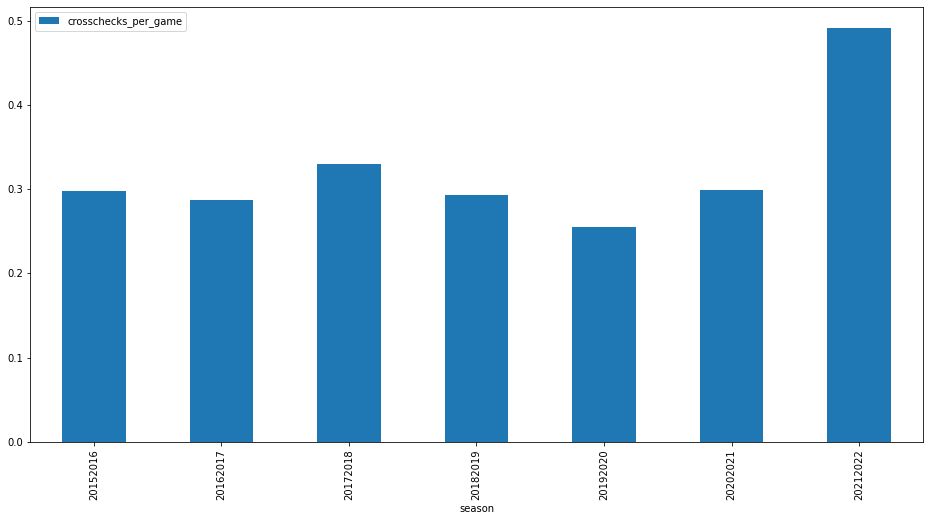

45.78109481029666


In [236]:
crosschecks_pergame.plot(y=['crosschecks_per_game'], x='season', kind = 'bar', figsize = [16,8])
plt.show()
print(crosschecks_pergame['defenseman_perc'].mean())

##Conclusions

So can we make some conclusion based on data? Absolutely, I would say. Ongoing season so far (01.01.2021) has had 64% more cross-checking penalties compared to last season. 

Most likely the numbers will drop a bit, when players need to adjust their game so that they wont take so much penalties due to this "rule change". 

Also, I had a feeling that most cross-checking penalties are called for defensemen, but surprisingly seems that by average only ~46% of seasons cross-checking penalties are called for defensemen. So the stereotype of slow and "old-school tough" defenseman is the type of player is prone to cross-checking penalties might not be true at all.  